initial testing 

In [1]:
# ⬛️ Cell 1 – Imports & Paths
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # optional, comment out if you don’t have it

# Dataset root (relative to project root)
DATA_ROOT = Path("AZT1D 2025")
CGM_DIR   = DATA_ROOT / "CGM Records"

# Display the directory tree to sanity-check paths
print("\n".join([str(p) for p in DATA_ROOT.rglob("*")][:20]))  # first 20 paths


AZT1D 2025/.DS_Store
AZT1D 2025/Visual Statistics
AZT1D 2025/CGM Records
AZT1D 2025/README.txt
AZT1D 2025/Manuscript.pdf
AZT1D 2025/Visual Statistics/Subject 5
AZT1D 2025/Visual Statistics/Subject 2
AZT1D 2025/Visual Statistics/Subject 3
AZT1D 2025/Visual Statistics/Subject 4
AZT1D 2025/Visual Statistics/Subject 11
AZT1D 2025/Visual Statistics/Subject 16
AZT1D 2025/Visual Statistics/Subject 20
AZT1D 2025/Visual Statistics/.DS_Store
AZT1D 2025/Visual Statistics/Subject 18
AZT1D 2025/Visual Statistics/Subject 19
AZT1D 2025/Visual Statistics/Subject 21
AZT1D 2025/Visual Statistics/Subject 17
AZT1D 2025/Visual Statistics/Subject 10
AZT1D 2025/Visual Statistics/Subject 8
AZT1D 2025/Visual Statistics/Subject 1


In [2]:
# ⬛️ Cell 2 – List subject folders & CSVs
SUBJ_FOLDERS = sorted((CGM_DIR).glob("Subject *"))
print(f"Found {len(SUBJ_FOLDERS)} subjects:")
for p in SUBJ_FOLDERS:
    csvs = list(p.glob("*.csv"))
    print(f"  {p.name}/  →  {csvs[0].name if csvs else '⚠️ NO CSV'}")


Found 25 subjects:
  Subject 1/  →  Subject 1.csv
  Subject 10/  →  Subject 10.csv
  Subject 11/  →  Subject 11.csv
  Subject 12/  →  Subject 12.csv
  Subject 13/  →  Subject 13.csv
  Subject 14/  →  Subject 14.csv
  Subject 15/  →  Subject 15.csv
  Subject 16/  →  Subject 16.csv
  Subject 17/  →  Subject 17.csv
  Subject 18/  →  Subject 18.csv
  Subject 19/  →  Subject 19.csv
  Subject 2/  →  Subject 2.csv
  Subject 20/  →  Subject 20.csv
  Subject 21/  →  Subject 21.csv
  Subject 22/  →  Subject 22.csv
  Subject 23/  →  Subject 23.csv
  Subject 24/  →  Subject 24.csv
  Subject 25/  →  Subject 25.csv
  Subject 3/  →  Subject 3.csv
  Subject 4/  →  Subject 4.csv
  Subject 5/  →  Subject 5.csv
  Subject 6/  →  Subject 6.csv
  Subject 7/  →  Subject 7.csv
  Subject 8/  →  Subject 8.csv
  Subject 9/  →  Subject 9.csv


In [3]:
# ⬛️ Cell 3 – Helper to load one subject
def load_subject_csv(subject_path: Path) -> pd.DataFrame:
    """Load the single CSV inside a subject folder, append SubjectID column."""
    csv_file = next(subject_path.glob("*.csv"))
    df = pd.read_csv(csv_file)
    df["SubjectID"] = subject_path.name  # e.g., "Subject 4"
    return df

# Quick sanity-check on first subject
test_df = load_subject_csv(SUBJ_FOLDERS[0])
display(test_df.head())
print(test_df.dtypes)


,EventDateTime,DeviceMode,BolusType,Basal,CorrectionDelivered,TotalBolusInsulinDelivered,FoodDelivered,CarbSize,CGM,SubjectID
0,2023-12-08 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151,Subject 1
1,2023-12-08 00:09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152,Subject 1
2,2023-12-08 00:14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156,Subject 1
3,2023-12-08 00:19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158,Subject 1
4,2023-12-08 00:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160,Subject 1


EventDateTime                  object
DeviceMode                    float64
BolusType                      object
Basal                         float64
CorrectionDelivered           float64
TotalBolusInsulinDelivered    float64
FoodDelivered                 float64
CarbSize                      float64
CGM                             int64
SubjectID                      object
dtype: object


In [4]:
test_df["EventDateTime"] = pd.to_datetime(test_df["EventDateTime"])
gaps = test_df["EventDateTime"].diff().dt.total_seconds().value_counts().sort_index()
print(gaps.head())          # expect 300 s for 5-min CGM cadence


EventDateTime
0.0         161
300.0     10846
600.0         6
900.0         2
1200.0        6
Name: count, dtype: int64


In [21]:
# ⬛️ Cell 4 – parse dates + basic hygiene
df = pd.concat([load_subject_csv(p) for p in SUBJ_FOLDERS], ignore_index=True)
df["EventDateTime"] = pd.to_datetime(df["EventDateTime"])
df = df.sort_values(["SubjectID", "EventDateTime"])

# quick null overview
display(df.isna().mean().sort_values(ascending=False).to_frame("null_frac"))


,null_frac
Readings (CGM / BGM),0.957605
BolusType,0.938268
CorrectionDelivered,0.938268
TotalBolusInsulinDelivered,0.938268
FoodDelivered,0.938268
CarbSize,0.938268
DeviceMode,0.780155
Basal,0.345024
CGM,0.042395
EventDateTime,0.000000


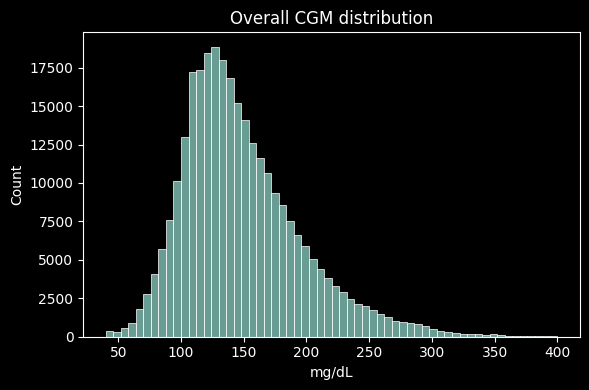

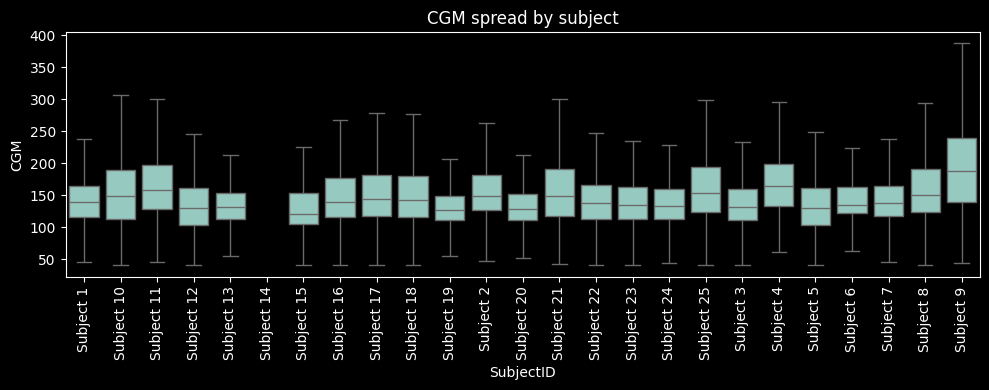

In [22]:
# ⬛️ Cell 5
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(df["CGM"].dropna(), bins=60, ax=ax)
ax.set(title="Overall CGM distribution", xlabel="mg/dL")
plt.tight_layout()

# per-subject violin / box
plt.figure(figsize=(10,4))
sns.boxplot(data=df, x="SubjectID", y="CGM", showfliers=False)
plt.xticks(rotation=90); plt.title("CGM spread by subject"); plt.tight_layout()


/var/folders/8c/gvnpx5795p37wpbf29lr1jl40000gn/T/ipykernel_71883/94553968.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(tir)


SubjectID
Subject 9     44.7
Subject 4     63.2
Subject 11    64.9
Subject 25    67.5
Subject 8     68.1
Subject 10    69.2
Subject 21    69.4
Subject 17    73.3
Subject 2     74.6
Subject 18    75.0
Subject 16    76.5
Subject 5     81.3
Subject 15    81.9
Subject 22    82.1
Subject 3     83.0
Subject 23    83.1
Subject 12    83.4
Subject 1     84.1
Subject 7     85.0
Subject 24    85.0
Subject 6     85.2
Subject 19    89.8
Subject 20    90.0
Subject 13    92.4
Subject 14     NaN
Name: TIR_%, dtype: float64

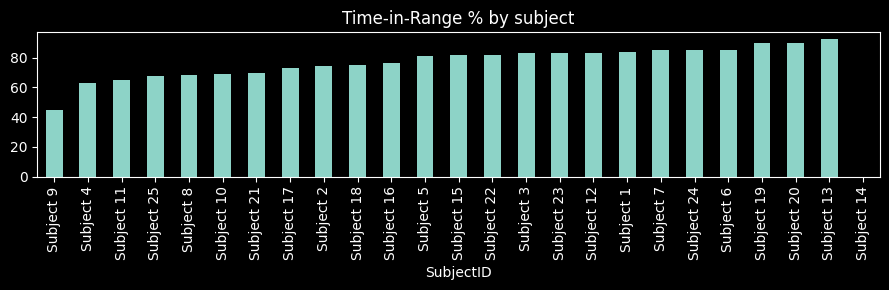

In [26]:
#Time-in-Range metrics (70-180 mg/dL)

def tir(sub):
    cgm = sub["CGM"].dropna()
    # round() built-in, not the pandas method
    return round(cgm.between(70, 180).mean() * 100, 1)

tir_df = (
    df.groupby("SubjectID")
      .apply(tir)
      .rename("TIR_%")
      .sort_values()
)

display(tir_df)
tir_df.plot.bar(figsize=(9,3), title="Time-in-Range % by subject"); plt.tight_layout()


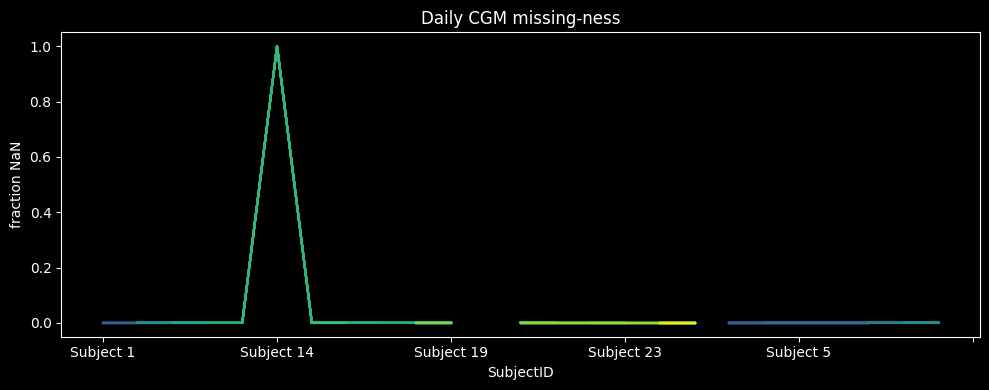

In [27]:
# ⬛️ Cell 7 – fraction of missing CGM per day
miss = (df.assign(date=df["EventDateTime"].dt.date)
          .groupby(["SubjectID","date"])["CGM"]
          .apply(lambda s: s.isna().mean()))
miss.unstack(0).T.plot(figsize=(10,4), cmap="viridis", legend=False)
plt.title("Daily CGM missing-ness"); plt.ylabel("fraction NaN"); plt.tight_layout()


### Quick-take synthesis

| Signal                                                           | What it tells us                                                                                   | Implications for the MVP                                                                                                                                             |
| ---------------------------------------------------------------- | -------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Null audit** <br>*(CGM \~4 % NaN, most other columns 78–96 %)* | We essentially have **only CGM + occasional basal** at scale. 99 % of bolus/food fields are blank. | 1. MVP rules must **not depend on carb / bolus data** yet. <br>2. Treat non-CGM columns as *nice-to-have* inputs—flag in loader & drop from model if coverage <10 %. |
| **CGM distribution**                                             | Classic right-skew (median ≈ 140 mg/dL, tail to 350 +).                                            | Good baseline for alert thresholds → reinforce 180 mg/dL hyper border.                                                                                               |
| **TIR% spread (≈ 45 % → 90 %)**                                  | Huge inter-subject variability; a few star performers & one clear straggler (Subject 9).           | Personalised advice matters—agent should compare each kid to **their own 2-week rolling baseline**, not cohort median.                                               |
| **Missingness heat-map**                                         | One giant dropout spike on Subject 14; otherwise sensors stay online.                              | Simple “% sensor-on last 24 h” metric will be robust. Rapid alert if >20 % missing.                                                                                  |
| **Daily stats / zones plots**                                    | Day-level metrics and zone counts make trends obvious; visual overlays (insulin/food) look great.  | These canned PNGs are perfect for first-iteration **report endpoints**. Expose them via `/visual/{subject}/{date}` so the front-end can lazy-load.                   |
| **Per-day CGM trace with annotations**                           | Already answers “what happened yesterday?” in one graphic.                                         | Re-use the underlying code in the agent’s weekly summary (attach 3 worst days).                                                                                      |

---

### 🛠️ Suggested next notebook cells (light lift, high ROI)

1. **Glycaemic Variability Indexes**

   ```python
   gv = (df.groupby("SubjectID")["CGM"]
           .apply(lambda s: s.std()).rename("SD mg/dL"))
   display(gv.sort_values())
   ```

   Use SD > 60 as a flag for “high variability”.

2. **Overnight Δ rule prototype**

   ```python
   def overnight_rise(sub):
       night = sub.set_index("EventDateTime")["CGM"].between_time("03:00","06:00")
       return night.iloc[-1] - night.iloc[0]  # mg/dL
   ```

   Store per-subject distribution → choose data-driven 30 mg/dL cutoff.

3. **Correlation of basal vs BG** (where data exists) to sanity-check insulin imprint.

4. **Rolling 14-day dashboard** – small dataframe with TIR, Avg BG, SD, # hypers, sensor-on%.

---

### 📦 How to productise the visuals

* **File naming is already API-friendly.** Serve via static file route:
  `/static/viz/<subject>/<image>.png`
* Add a helper in FastAPI:

  ```python
  @app.get("/visual/{subject}/{name}")
  def get_viz(subject: str, name: str):
      path = DATA_ROOT / "Visual Statistics" / subject / name
      return FileResponse(path)
  ```
* Front-end: thumbnail grid that expands to full-size modal—zero extra backend work.

---



**Overall: great first pass.** Most heavy-lifting on EDA is done; data quality quirks are clear; visuals are asset-ready. Let’s pivot to wiring these insights into code paths the agent can tap. Ping me when the parquet + metrics JSON are pushed and I’ll flesh out the proactive-alert logic.
